# Linear Regression Assumptions and Inference

In this lecture we think about linear regression as a **statistical model**.

Let's see what additional assumptions and checks we must make to use linear regression in this way.

For this lecture you'll need to install the [py-glm](https://github.com/madrury/py-glm) package.

In [1]:
!pip install git+https://github.com/madrury/py-glm.git

  Cloning https://github.com/madrury/py-glm.git to /tmp/pip-req-build-7jq40o69
  Running command git clone -q https://github.com/madrury/py-glm.git /tmp/pip-req-build-7jq40o69
  Created wheel for py-glm: filename=py_glm-0.0.1-py3-none-any.whl size=15915 sha256=31a75890189a72fc84de1f7fbb39ce09397be18c24a065f4ffbb806e0c1abac3
  Stored in directory: /tmp/pip-ephem-wheel-cache-uand_6a8/wheels/3c/55/40/f95fda234109c19895938acde69c5c38dafd71b9b0b6360e77
Successfully built py-glm


In [2]:
from math import ceil
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from glm.glm import GLM
from glm.families import Gaussian

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Statistical Models Revisited

Recall our working definition of **statistical model** as a catalog of ways we believe the data could have been generated, and **fitting a statistical model** as combining this catalog with data to determine a single option from this catalog that we most believe generated the data we actually have.

We developed the **maximum likelihood principle** as a way to make the procedure of choosing the "best" option from the catalog.

So far our discussion of regression has not followed this line.  Instead we viewed it as simply fitting a line or curve to data, with the success of this judged on how well predictions from that line or curve held up on test data.

## Properties of the Coefficients

Our goal with inferential linear regression is to build the "best" linear model. We assume the values of $y$ are generated from a linear equation:

$$ y = \beta_0 + \beta_1 f_1 + \beta_2 f_2 + \cdots + \beta_k f_k + \text{noise} $$

(more on this below) and then try to find the best values of $\hat \beta_i$ to approximate $\beta_i$.

When we talk about

**Existence**: There should be one and only one solution for the best value of $\hat \beta$.

**Consistency**: In statistics, an estimator is said to be consistent if it converges to the "true" value for larger and larger samples. I.e., $\hat \beta \to \beta$ as $n \to \infty$

**Unbiasedness**: If we were to average $\hat \beta$ over many samples, it would converge to correct value, i.e., $\mathbb{E}[\hat \beta] = \beta$


## The Linear Regression Assumptions

Linear regression is often presented along with a list of assumptions.

#### The Linear Regression Assumptions:
  - Linearity
  - Linear Independence of Features
  - Independence of Data
  - Homoscedasticity
  - Normal Distribution of Errors
  
These assumptions are not all needed, nor must they all be checked, for all applications of linear regression.  Indeed, when used as a **predictive** model, only the first is really needed (though some of the others bear consequences when blatantly violated).

We will take these assumptions in turn, discussing what the assumption means and what can happen when it is violated.

## The Linearity Assumption

Recall that the "linear" in the name "linear regression" does **not** mean that the model is attempting to fit a linear function of the **raw features**.  Instead, it means that the model is a linear function of the **transformed features**.

So, the **linearity assumption** in regression says that the **model fits the data well**.  I.e., that $y$ is a **linear function of the (possibly transformed) features in the model**.  Of course, $y$ cannot be an exact linear function, because there is some randomness involved, but this should be the **only reason** that $y$ is not a linear function of the features.

$$ y = \beta_0 + \beta_1 f_1 + \beta_2 f_2 + \cdots + \beta_k f_k + \text{noise} $$

The residuals vs. feature plots we looked at in the linear regression day can be used to assess this asumption.

In [3]:
x = stats.uniform(-2, 6).rvs(500)
y = 1 + x - 0.5 * x * x + stats.norm(0, 1).rvs(500)

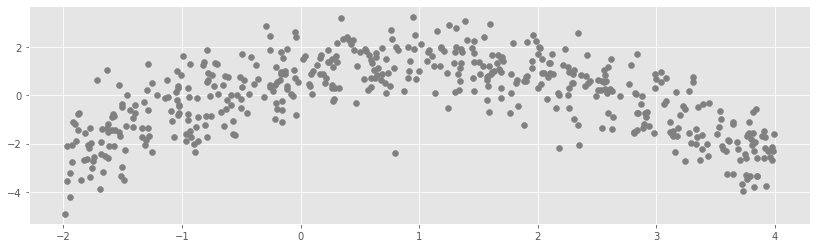

In [4]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x, y, color="grey");

Notice how this data looks like it fits some kind of relationship like:
    
$$ y \mid x = \beta_0 + \beta_1 x + \beta_2 x^2 + \text{noise} $$

We just don't know what the numbers $\beta_0, \beta_1, \beta_2$ are.  This is a **description of how the data was generated**, and so meets our definition of a statistical model.  

In [5]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

By using a quadratic transformation of the predictor, we can fit this model to our data.

In [6]:
X = np.empty((len(x), 2))
X[:, 0] = x
X[:, 1] = x**2

quadratic_model = LinearRegression()
quadratic_model.fit(X, y)

y_hat = quadratic_model.predict(X)

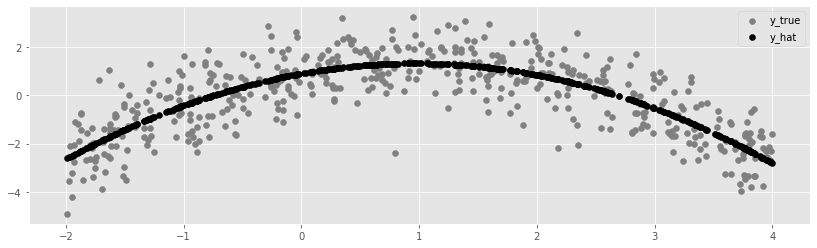

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x, y, color="grey", label='y_true')
ax.scatter(x, y_hat, color="k", label='y_hat')
ax.legend();

The residual plots show no obvious pattern, which is a hint that we specified our statistical model correctly. 

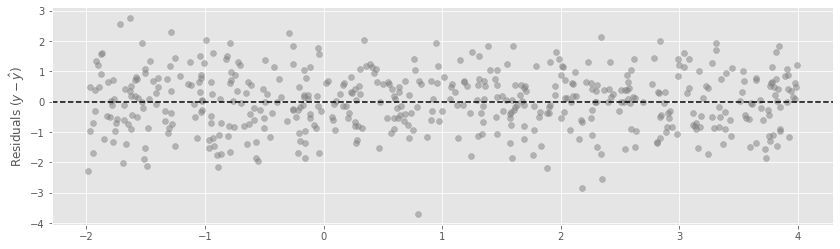

In [8]:
fig, ax = plt.subplots(figsize=(14, 4))
residual_plot(ax, x, y, y_hat)

If we had instead used the model

$$ y \mid x = \beta_0 + \beta_1 x + \text{error} $$

we would end up with a residual plot containing an obvious patter, which is a hint that we have **misspecified** our statistical model.

In [9]:
linear_model = LinearRegression()
linear_model.fit(x.reshape(-1, 1), y)

y_hat = linear_model.predict(x.reshape(-1, 1))

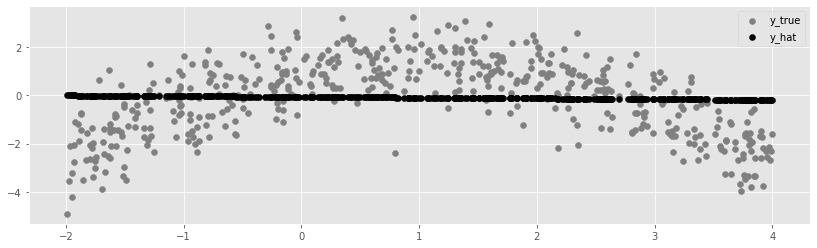

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x, y, color="grey", label='y_true')
ax.scatter(x, y_hat, color="k", label='y_hat')
ax.legend();

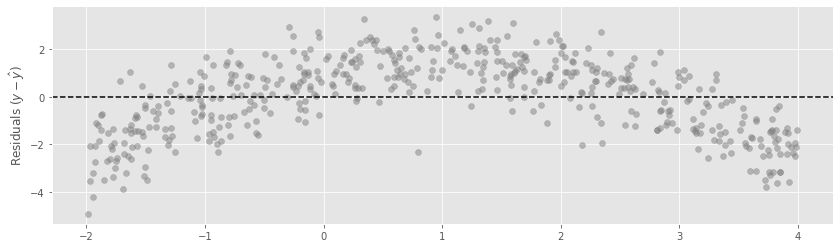

In [11]:
fig, ax = plt.subplots(figsize=(14, 4))
residual_plot(ax, x, y, y_hat)

We clearly do not have a band evenly spaced around the center line. This type of plot indicates that something is missing from the model.

The linearity assumption for linear regression is essentially the desire that **the model we fit to our data is well specified, i.e. it contains the true (or close to the true) process that generated the data.**

## Linear Independence and Multicollinearity

In order to find a unique solution, the features must be **linearly independent** from one another (i.e., not multicollinear).

If this is not true, then there are an infinite number of possible solutions. This doesn't prevent choosing a solution and using it for prediction, but it is problematic when defining an inferential model.

In real life, this won't happen unless the features are derived from a common source, or there are few data points. More commonly, one feature is strongly correlated with a linear combinations of other features. In this case there will be a single solution, but the values for coefficients $\beta$ will be have a high variance base on the individual sample.

Check for this using the [variance_inflation_factor.](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

## The Independence Assumption and Consistency

The consistency of linear regression addresses the effect of gathering more **independent** data.  We would like the regression to become more and more accurate as we feed it more training data.

**Question:** Accurate with reference to what?

The idea is this:  if our data were **truly** generated from a random process like this:

$$ y \mid X \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{noise} $$

Then the coefficients we get from fitting a linear regression can be considered as **estimates of the true parameters**:

$$ \underbrace{\hat \beta_k}_{\text{The Coefficients from the Fit Regression}} \underbrace{\approx}_{\text{Are approximations of}} \underbrace{\beta_k}_{\text{The True Parameters}} $$

**Consistency** is the statement that this approximation gets **better** as we collect more data.

In [12]:
def plot_regressions(ax, n, num=50):
    for k in range(num):
        x = stats.uniform(-1, 2).rvs(n)
        y = 2*x + stats.norm(0.0, 1.0).rvs(n)
        if k == 0:
            ax.scatter(x, y, color="grey")
        model = LinearRegression()
        model.fit(x.reshape(-1, 1), y)
        t = np.linspace(-1, 1, num=250)
        ax.plot(t, model.predict(t.reshape(-1, 1)), color="grey", alpha=0.5)

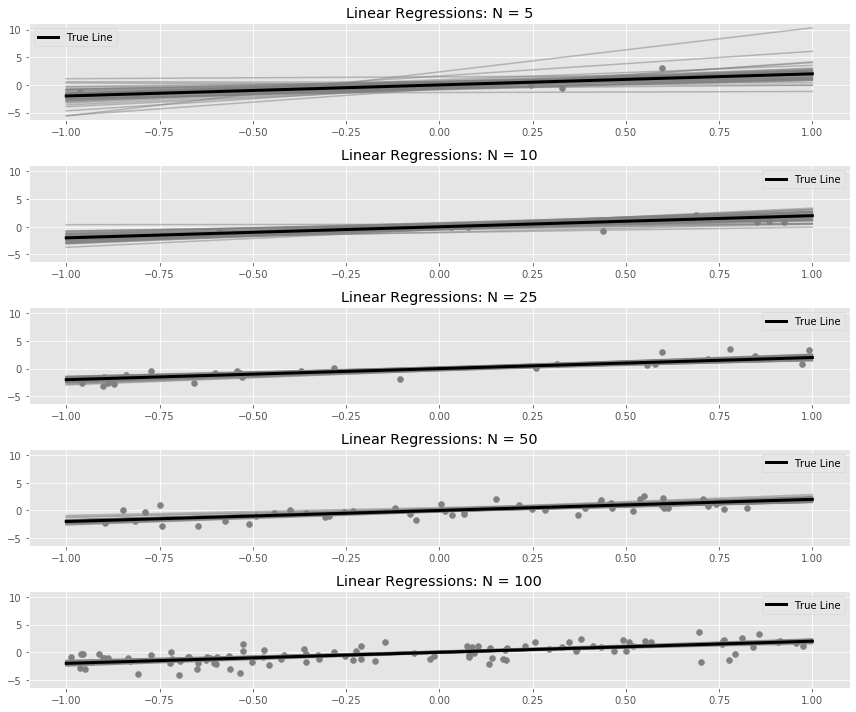

In [13]:
ns = [5, 10, 25, 50, 100]

fig, axs = plt.subplots(len(ns), figsize=(12, 10), sharey=True)
for ax, n in zip(axs, ns):
    plot_regressions(ax, n)
    ax.plot([-1, 1], [-2, 2], color="black", linewidth=3, label="True Line")
    ax.set_title(f"Linear Regressions: N = {n}")
    ax.legend()
fig.tight_layout()

Linear regression is consistent as long as the **data** are independent.  That is, each sampled data point $(X, Y)$ must be independent from all other data points.  When data are independent, each additional data point gives us **more information**, which allows us to better estimate the regression line.

As an example of how this assumption can be violated, consider data that is generated from an iterative procedure like:

$$ y_k = y_{k-1} + \text{error} $$

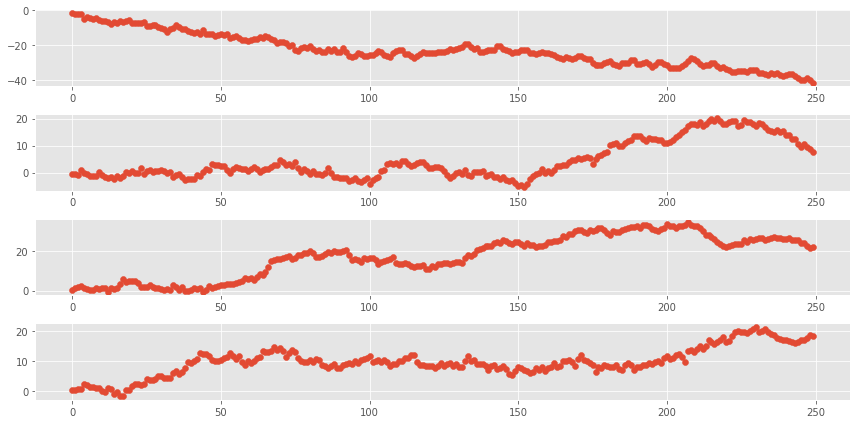

In [14]:
n_walks = 4

fig, axs = plt.subplots(4, figsize=(12, 6))

x = np.arange(250)
for ax in axs.flatten():
    y = np.random.normal(size=250)
    walk = np.cumsum(y)
    ax.scatter(x, walk)
    
plt.tight_layout()

This type of data is often called **time series** data, and it is *not* independently sampled. We'll talk more about time-series data later in the course.

## Normality of Errors: Distribution of Parameter Estimates

The **most information we could possibly have** about the probabilistic nature of linear regression is to know the **distribution of the parameter estimates / coefficients**.

### What This Means

It's important to understand what this means.

The parameter estimates / coefficients from a fit linear regression are **random quantities**.  If we have different sample of data from our population, fitting a linear regression will give us slightly different results. So...

$$ \hat \beta \text{ is a random variable!} $$

**Note:** We have already observed that when the data are independent, more data will cause these different results to converge to the same answer.  This is consistency!

The most we could ask for is a complete description of the distribution of the coefficients.  This is available in some circumstances, but it **requires very stringent assumptions**!

In [15]:
def run_one_regression(n, noise=stats.norm(0, 1)):
    x1 = stats.uniform(-1, 2).rvs(n)
    x2 = stats.uniform(-0.5, 1.0).rvs(n)
    x3 = stats.uniform(-2, 4).rvs(n)
    y = 1 + x1 - 2*x2 + noise.rvs(n)
    X = np.empty(shape=(n, 3))
    X[:, 0] = x1; X[:, 1] = x2; X[:, 2] = x3
    model = LinearRegression()
    model.fit(X, y)
    return X, y, model.coef_

def simulate_many_coeffs(n, n_sim=5000, noise=stats.norm(0, 1)):
    coeffs = np.empty(shape=(n_sim, 3))
    for i in range(n_sim):
        _, _, coeffs[i, :] = run_one_regression(n, noise=noise)
    return coeffs

def plot_paramter_estimate_histograms(axs, coeffs):
    axs[0].hist(coeffs[:, 0], bins=100, color="grey", alpha=0.5, 
                density=True, label="Parameter Estimates: Observed")
    axs[0].set_title(r"Distribution of $\hat \beta_1$")
    axs[0].axvline(1, color="black", label=r"True Parameter $\beta_1$")
    axs[0].legend()

    axs[1].hist(coeffs[:, 1], bins=100, color="grey", alpha=0.5,
                density=True, label="Parameter Estimates: Observed")
    axs[1].set_title(r"Distribution of $\hat \beta_2$")
    axs[1].axvline(-2, color="black", label=r"True Parameter $\beta_2$")
    axs[1].legend()


    axs[2].hist(coeffs[:, 2], bins=100, color="grey", alpha=0.5,
                density=True, label="Parameter Estimates: Observed")
    axs[2].set_title(r"Distribution of $\hat \beta_3$")
    axs[2].axvline(0, color="black", label=r"True Parameter $\beta_3$")
    axs[2].legend()

In [16]:
X, y, _ = run_one_regression(100, noise=stats.norm(0, 1))
coeffs = simulate_many_coeffs(100, noise=stats.norm(0, 1))

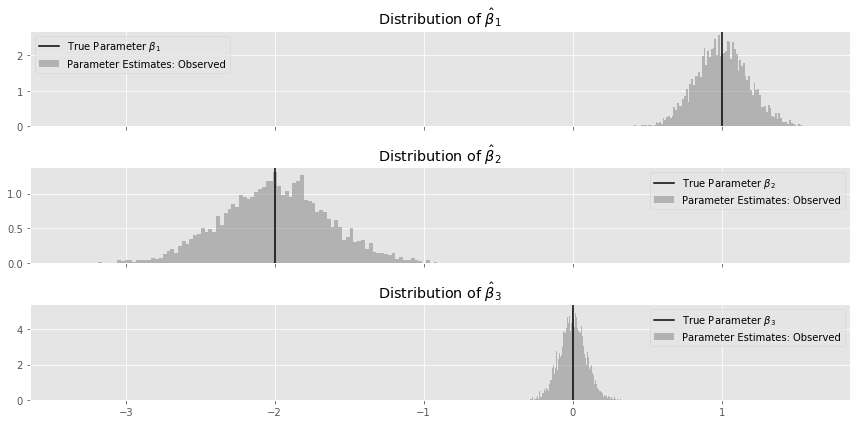

In [17]:
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
plot_paramter_estimate_histograms(axs, coeffs)
fig.tight_layout()

The usual assumption / consequence is this:

**When the noise is assumed to be normally distributed (centered at zero, variance does not depend on x), then the parameter estimates are ALSO normally distributed**.

We can write that assumption in rigorous notation as:

$$ y \mid x \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{Normal}(0, \sigma) $$

Sigma here must **not depend on $x$**.  This specific property is called **homoscedasticity**.

**Non-homoscedastic (i.e., heteroscedastic)** data has a conditional variance that changes as the feature changes.  For example, if we generate data from a process like

$$ y \mid x \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{Normal}(0, x) $$

In [18]:
x = np.random.uniform(low=1.0, high=5.0, size=500)
y2 = 1 + 5*x + np.random.normal(scale=x)

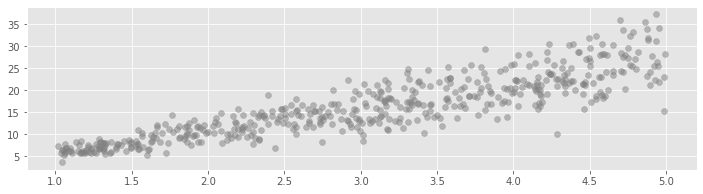

In [19]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(x, y2, color="grey", alpha=0.5);

The topic of **Generalized Linear Models** addresses statistical inference  when data is heteroscedastic.  

If you see this behavior - usually some form of tranformation (like a [log transformation](http://onlinestatbook.com/2/transformations/log.html)) of the feature or data can be used to make it more homoscedastic.

## Example: Applications to Inference

The most common application of all these ideas is in the hypothesis testing of regression coefficuents.

Let's use our model of insect wing sizes to answer an inferential question: 

> Does continent have any effect on wing size?

To accomplish this, we need to pre-specify a regression model relating the wing size of insects to all other relevant measurement.  We've already done this work, so I'll just remind everyone of our final model:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent} $$

Then the new number $e$ captures the effect of the insect being found on the continent labeled $1$.  **If $e$ is zero, or close to zero, then continent has no effect on wing span**.

Let's reload the data:

In [20]:
insects = pd.read_csv('./data/insects.csv', sep='\t')
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


Let's estimate the model:

In [21]:
insects_model_quad_with_continent = GLM(family=Gaussian())
insects_model_quad_with_continent.fit(
    insects,
    formula='wingsize ~ latitude + I(latitude**2) + sex + continent')
insects_model_quad_with_continent.summary()

Gaussian GLM Model Summary.
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept               1945.39           91.51
latitude                 -42.96            3.88
I(latitude ** 2)           0.45            0.04
sex                      -89.90            3.81
continent                 -4.11            3.58


Those `standard errors` are what we computed with our $\sigma (X^t X)^{-1}$ calculation.

## Linear Regression p-values

Recall that a **p-value** describes the amount of surprise that we feel when observing data, given that we are taking a skeptical stance on how that data is generated.

$$ P(\text{Observing A Statistic Equal or More Extreme than Actual} \mid H_0) $$

So to make sense of the p-values here, we need to describe the **null hypothesis** and the **statistic**.

The **null hypothesis** in this case is that each value of $y$ was generated by sampling from a relationship like:

$$ y \mid x \sim N(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + 0 \times \text{Continent}, \sigma) $$

Notice that in the null hypothesis, we are assuming **the effect of continent is zero, so we would be surprised to find it very non-zero**.

Given this null hypothesis, the **p-value** reported in linear regression is

$$ P(\text{Observe a Parameter Estimate for Continent More Extreme Than the Fit Model} \mid H_0) $$

We can extract the p-values from our fit regression model with the `_p_value` attribute:

In [22]:
names = insects_model_quad_with_continent.X_names
p_values = insects_model_quad_with_continent.p_values_

print("Predictor            p-value")
print("-"*30)
for name, p in zip(names, p_values):
    print(f"{name :<20} {p:2.3f}")

Predictor            p-value
------------------------------
Intercept            0.000
latitude             0.000
I(latitude ** 2)     0.000
sex                  0.000
continent            0.251


Our p-value for continent was $0.25$, so it's quite likely that we would observe a parameter estimate equally or more extreme than we actually did, even if the true effect was zero.  This is consistent with what we saw in our picture, we do **not** believe that `continent` has an effect much different than zero.

## A Final Word on Assumptions

There is a subtlety to our hypothesis test above.

The Null Hypothesis can be **false in more than one way**:

  - It could be, as we discussed already, that the true effect of `continent` is *not-zero*.  This is the situation we are trying to detect.
  - It could be that the value of $y$ was **not created by sampling from a normal distribution centered at the predicted value**.
  
For example, it could be that the value of $y$ was created by sampling from some other distribution:

$$ y \mid x \sim \text{Exponential}(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent}) $$

In this case we **cannot deduce that $e \neq 0$, even if we reject the null hypothesis**.

**The calculation of p-values in a linear regression depends on ALL THE ASSUMPTIONS ABOVE being true**.  If **any** of them are false, the calculation of the p-value is **not valid**.